In [2]:
# Input data files are available in the read-only "../input/" directory
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/gsm3516673-lung-tissue/GSM3516673_MSK_LX682_NORMAL_dense.csv


##  <font color='purple'>Analysis of Lung single cell RNA-seq data</font>


Aim of this project is to identify cell types and annotate the clusters of lung tissue sc RNA sequencing data. The data used in this analyis is a [patient adjacent non-tumour involved lung tissue](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSM3516673) sample produced by Laughney et al. (2020) via the 10× Genomics Chromium platform. 


**Data Analysis Outline**

1. Load data into Anndata

2. Preprocessing

 2.1. Normalization

 2.2. Feature selection

 2.3. Quality control

3. Feature Reduction and Visualization

  3.1 Principal Component Analysis (PCA)

4. Downstream Analysis

 4.1. Clustering
 
 4.2 Differential Expression Analysis
 
 4.3. Marker Identification
 
 4.4. Cluster Annotation using CellO classifier
 
 4.5. Uniform Manifold Approximation and Projection (UMAP)
 
 4.6. Conclusion
 
 
 **Background Information: scRNA‐seq workflow**

Single cell data generation has multiple steps single‐cell dissociation, single‐cell isolation, library construction, and sequencing (Ziegenhain et al, 2017). The input material is biological tissue sample and single-cell suspension is generated by tissue digestion (single-cell dissociation). Cells are isolated in different ways depending on experimental protocol to profile mRNA in each cell separately. Plate-based method isolates cell in wells on a plate and droplet-based methods capture cells in microfluidic droplet. Some of the challenges are multiples cells being captured (doublets), non-viables cells or no cell being captures in wells/ droplets.

Each well/droplet contains chemicals to break cell membrane and perform library construction. In library contruction, intracellular mRNA is captured, reverse-transcribed to cDNA molecules and amplified (to increase the probability of being measured). During isolation, mRNA from each cell can be lebelled with well/droplet cellular barcode or unique molecular identifier (UMI). UMIs helps to distinguish between amplified copies of the same mRNA molecule and reads from separate mRNA molecules transcribed from the same gene (Luecken MD et al, Theis FJ et al, 2019).

The libraries generated are grouped together for sequencing. Read data from sequencing undergoes quality control, grouping based on barcodes and alignment. Read data is demultiplexed to generate count data in UMI-based protocols (Luecken MD et al, Theis FJ et al, 2019).

In [ ]:
# Install and load required packages
!pip install scanpy
!pip install scvi
!pip3 install leidenalg
!sudo apt-get install graphviz libgraphviz-dev graphviz-dev pkg-config -y
!pip install pygraphviz
!pip install leidenalg cello-classify

In [4]:
import scanpy as sc
import pandas as pd
import numpy as np
from matplotlib.pyplot import rc_context

import scvi
import os
from anndata import AnnData
import cello

/opt/conda/lib/python3.7/site-packages/scvi/__init__.py:31: DeprecationWarning: scvi is deprecated, please uninstall scvi via `pip uninstall scvi` and install the new scvi-tools package at github.com/YosefLab/scvi-tools
  warnings.warn(deprecation_msg, DeprecationWarning)


In [ ]:
sc.set_figure_params(dpi=100, color_map = 'viridis_r')
sc.settings.verbosity = 1
sc.logging.print_header()

## 1. Load data into Anndata

In [5]:
data_path ="../input/gsm3516673-lung-tissue/GSM3516673_MSK_LX682_NORMAL_dense.csv"

In [6]:
# load the expression matrix into a Pandas df
df = pd.read_csv(data_path,index_col=0)
df.head()

,TSPAN6,DPM1,SCYL3,C1ORF112,FGR,CFH,FUCA2,GCLC,NFYA,STPG1,...,RP11-24F11.5,RP5-958B11.1,WDFY4.1,RP11-244E17.1,RP11-57A19.7,RP11-419I17.1,RP3-454G6.2,AC013271.5,RP11-122G18.12,RP5-937E21.8
120703408789411,0,1,0,0,3,0,3,0,0,0,...,0,0,0,0,0,0,0,0,0,0
120703408793835,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
120703409145716,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
120703409339181,0,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
120703409379676,0,1,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Anndata is cell by gene expression matrix with row as cells and columns as genes and used by Scanpy library.

In [7]:
# Load the expression matrix using Pandas and Scanpy
adata = AnnData(df)
adata

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  
/opt/conda/lib/python3.7/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


AnnData object with n_obs × n_vars = 4061 × 18804

## 2. Preprocessing

In [ ]:
# Basic filtering
sc.pp.filter_cells(adata, min_genes=200) #  filter cells with fewer 200 genes detected
sc.pp.filter_genes(adata, min_cells=3) # filtered out genes that are detected in less than 3 cells

### 2.1. Normalization

As single-cell consists of wide-ranging cells with varying size and counts, it is important to scale the count data. Commonly used method is counts per million” (CPM), which normalizes count data using size factor proportional to the count depth per cell. 

Normalization can be performed based on the type of scRNA-seq techniques: full‐length and 3′ enrichment methods (Svensson et al, 2017; Ziegenhain et al, 2017, and Luecken MD et al, Theis FJ et al, 2019). The gene length normalization is particularly useful for full-length data and not for 3′ enrichment (e.g. Patel et al, 2014; Kowalczyk et al, 2015; Soneson & Robinson, 2018, and Luecken MD et al, Theis FJ et al, 2019)


After normalization, data is log(x+1)‐transformed as it will be required for next steps such as batch correction or differential expression analysis, which assume normal distribution and requires log transformation. Three uses of log transformation: changes in expression is meaured by log fold changes, reduction of mean-variance relationship in single-cell data and skewness (Brennecke et al, 2013; Finak et al, 2015; Ritchie et al, 2015; Johnson et al, 2006; Buttner et al, 2019).

In [10]:
# Normalize expression data into units of log transcripts per million
sc.pp.normalize_total(adata, target_sum=1e6)

# Logarithmize the data:
sc.pp.log1p(adata)

### 2.2 Feature Sellection: Selecting Highly variables genes

Selection of Higly variables genes (n_top_genes) is used for downstream analysis. Selection of high number of gene decreases the separation between different cell types. Selecting few genes will not result in clear distinction of granular cell types (Bernstein et al. 2021).

In [11]:
# Annotate the 10000 most highly expressed genes for performing clustering
sc.pp.highly_variable_genes(adata, n_top_genes=10000)
# sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

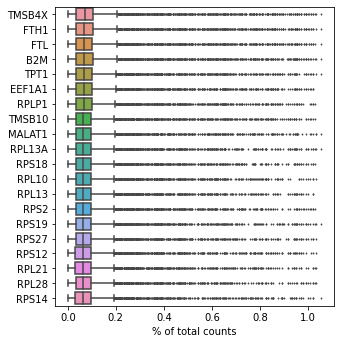

In [12]:
#Show those genes that yield the highest fraction of counts in each single cell, across all cells.
sc.pl.highest_expr_genes(adata, n_top=20,)


### 2.3 Quality control

There are three QC covariates (Ilicic et al, 2016; Griffiths et al, 2018, and Luecken MD et al, Theis FJ et al, 2019)

1. Count depth (the number of counts per barcode)
2. Number of genes per barcode
3. Fraction of counts from mitochondrial genes per barcode 


A violin plot is used for visualizing QC covariates. This helps in detection of outliers which correpond to dying cells, broken cell membrane and doublets. 
For example, cytoplasmic mRNA leakout through broken membrane is indicated by low count depth, few genes and high fraction of mitochondrial counts.
Conversely, high count depth and high gene detection indicated doublets (DoubletDecon: preprint: DePasquale et al, 2018 and Luecken MD et al, Theis FJ et al, 2019).

In [33]:
adata.var['mt'] = adata.var_names.str.startswith('MT-') # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:3641: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self[k1] = value[k2]


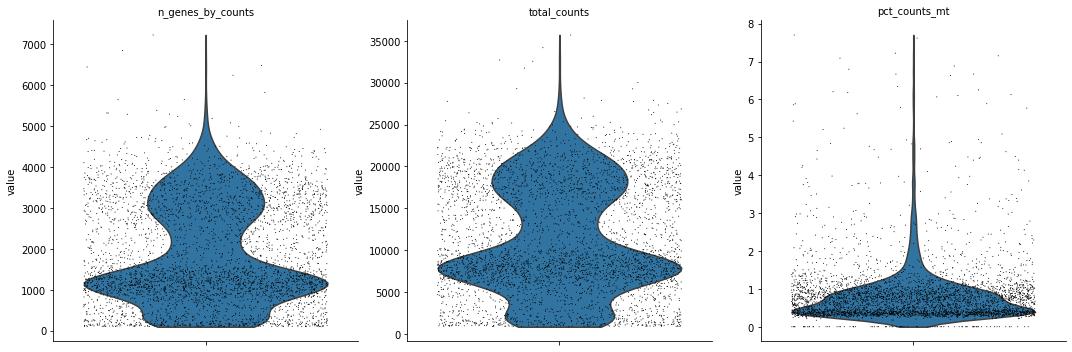

In [34]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

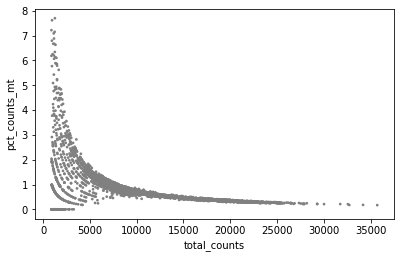

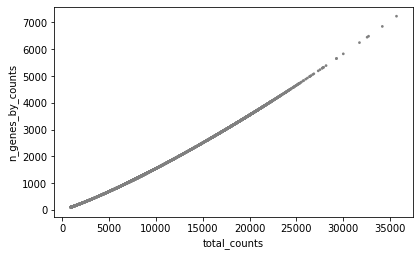

In [35]:
# Plot mitochondrial genes expressed and total counts
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

In [ ]:
# Filtering to remove cells that have too many mitochondrial genes expressed or too many total counts
adata = adata[adata.obs.n_genes_by_counts < 2500, :]
adata = adata[adata.obs.pct_counts_mt < 5, :]

In [ ]:
#adata = adata[:, adata.var.highly_variable]

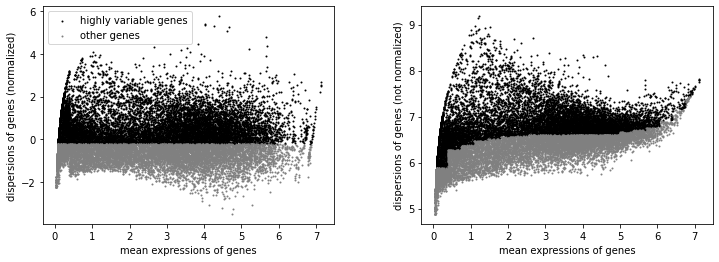

In [36]:
# Normalized vs Non-normalized mean expression of genes
sc.pl.highly_variable_genes(adata)


Even after normalization, a count depth effect can remain in the data. Regressing out count depth effects will increase performance of trajectory inference algorithms which find the transition between cells (Luecken MD et al, Theis FJ et al 2019)


In [ ]:
# Regress out effects of total counts per cell and the percentage of mitochondrial genes expressed
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])

### 3.1  Principal Component Analysis

Reduces dimensionality of the data. n_comps computes number of principal components. 

In [14]:
# principal components=5
sc.pp.pca(adata, n_comps=50, use_highly_variable=True)

In [ ]:
sc.pl.pca(adata)
#sc.pl.pca_variance_ratio(adata, log=True)

### 4.1 Clustering 

In [38]:
# Compute nearest-neighbors graph by finding the nearest 10 cells to each cell using the Euclidean distance 
sc.pp.neighbors(adata, n_neighbors=15)
sc.tl.leiden(adata, resolution=2.0) # Resolution: High values for this parameter result in smaller, more granular clusters

### 4.2 Differential Expression Analysis

Marker genes are identified by computing differential expression between groups: Cells in one cluster versus rest of the clusters. The genes that are upregulated or top-ranked genes in a cluster are its marker genes. Most commonly used methods are t-test and Wilcoxon rank-sum (Mann-Whitney-U). Using reference databases cells in the clusters can be identified and annotated.

In this analysis, we are using CellO, a Python package for annotating cell types in single-cell RNA-seq data (Matthew N. Bernstein et al, Colin N. Dewey et al 2021) to identify the cell types and annotate the clusters.

In [ ]:
# computing differential expression between groups using t-test
sc.tl.rank_genes_groups(adata,'leiden', method='t-test')

### 4.3 Marker Identification

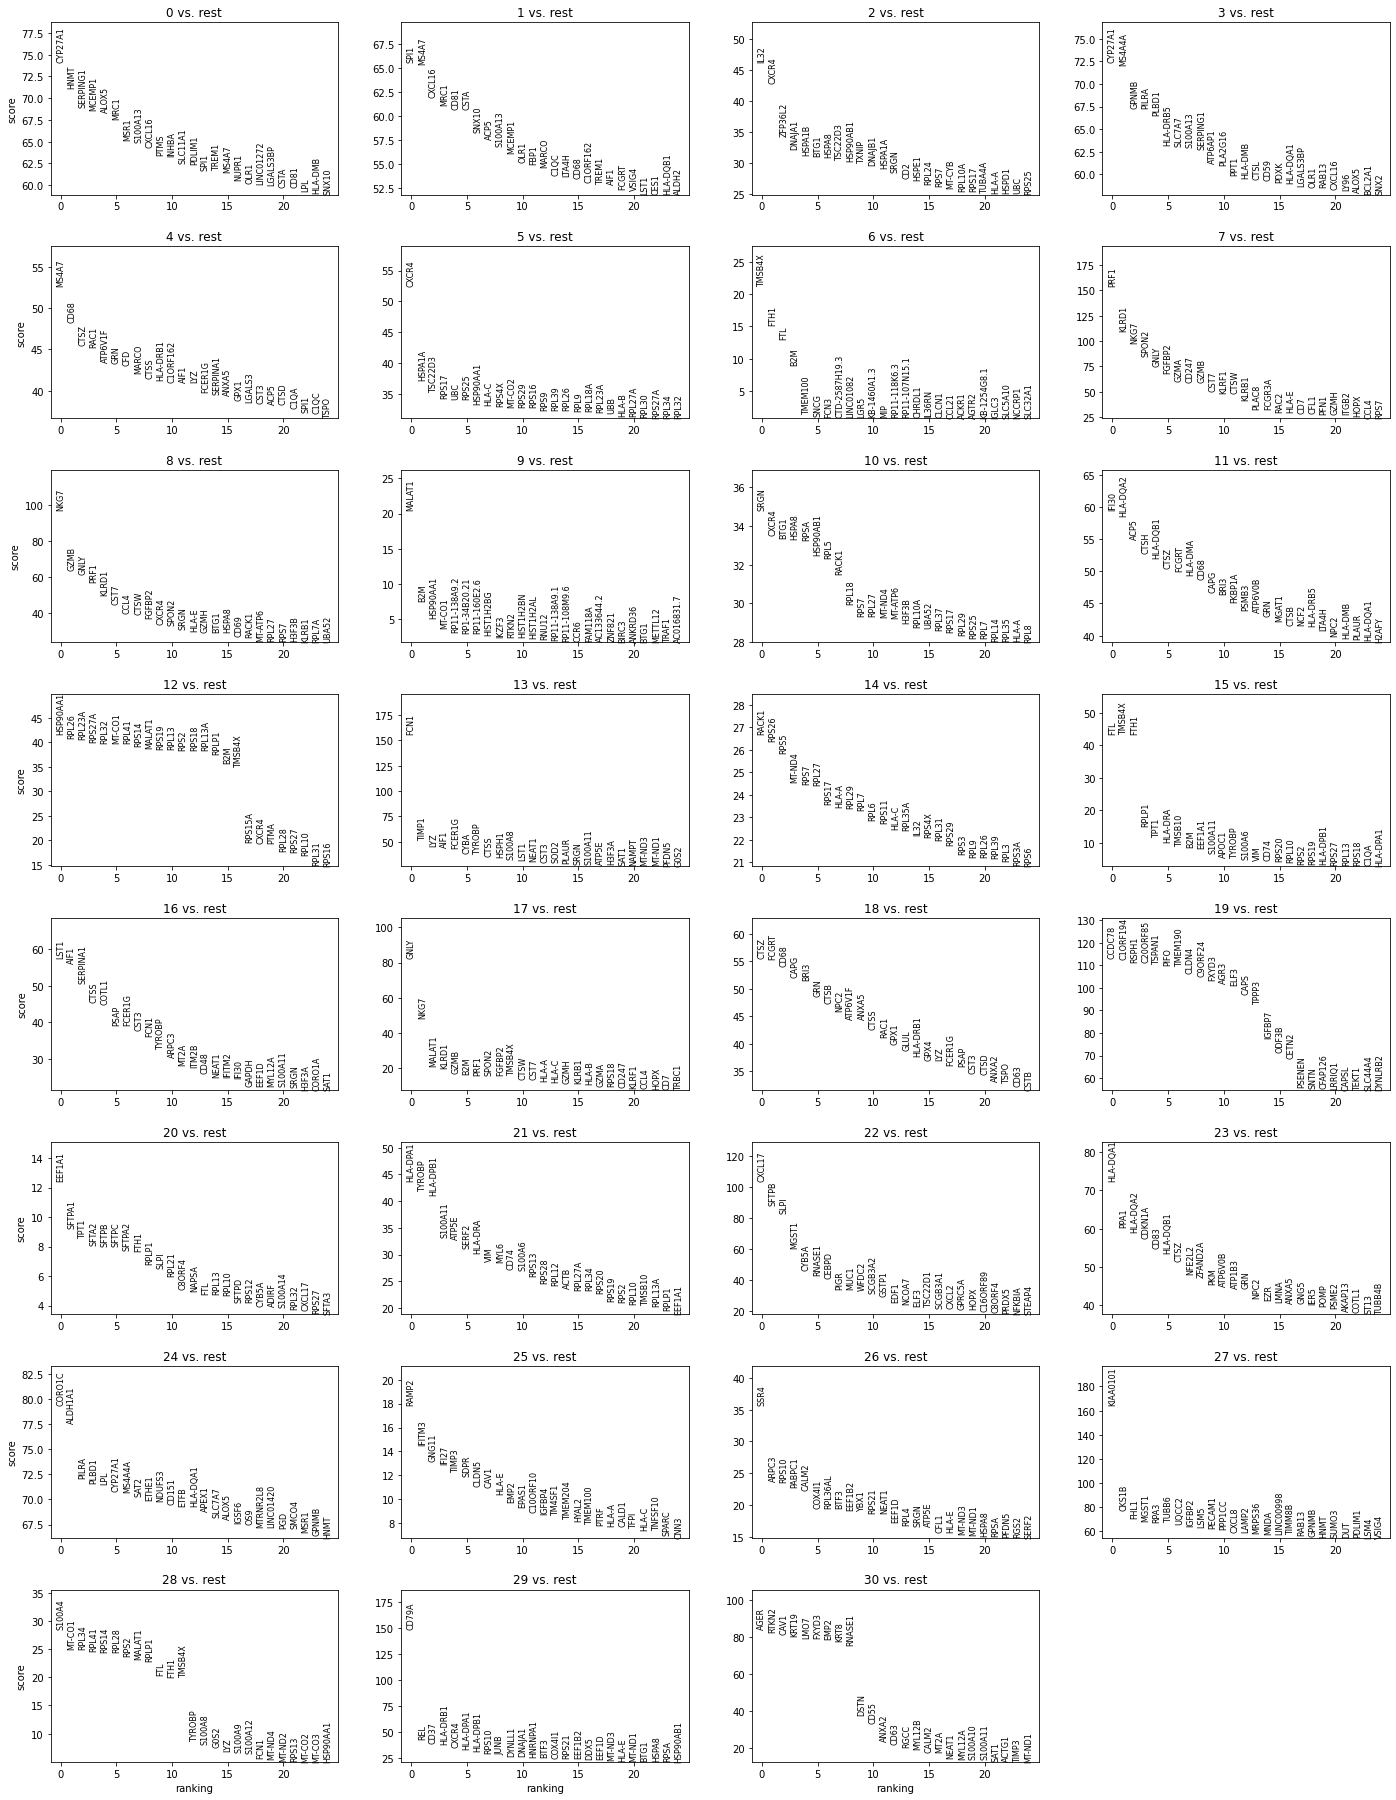

In [20]:
# Ranking the upregulated genes in each cluster
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False) 
#sc.settings.set_figure_params(dpi=160)

In [42]:
# Show the 25 top ranked genes per cluster 0, 1, …, 7 in a dataframe.
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(20)


,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
0,CYP27A1,SPI1,IL32,CYP27A1,MS4A7,CXCR4,TMSB4X,PRF1,NKG7,MALAT1,...,HLA-DPA1,CXCL17,HLA-DQA1,CORO1C,RAMP2,SSR4,KIAA0101,S100A4,CD79A,AGER
1,HNMT,MS4A7,CXCR4,MS4A4A,CD68,HSPA1A,FTH1,KLRD1,GZMB,B2M,...,TYROBP,SFTPB,PPA1,ALDH1A1,IFITM3,ARPC3,CKS1B,MT-CO1,REL,RTKN2
2,SERPING1,CXCL16,ZFP36L2,GPNMB,CTSZ,TSC22D3,FTL,NKG7,GNLY,HSP90AA1,...,HLA-DPB1,SLPI,HLA-DQA2,PILRA,GNG11,RPS10,FHL1,RPL34,CD37,CAV1
3,MCEMP1,MRC1,DNAJA1,PILRA,RAC1,RPS17,B2M,SPON2,PRF1,MT-CO1,...,S100A11,MGST1,CDKN1A,PLBD1,IFI27,PABPC1,MGST1,RPL41,HLA-DRB1,KRT19
4,ALOX5,CD81,HSPA1B,PLBD1,ATP6V1F,UBC,TMEM100,GNLY,KLRD1,RP11-138A9.2,...,ATP5E,CYB5A,CD83,LPL,TIMP3,CALM2,RPA3,RPS14,CXCR4,LMO7
5,MRC1,CSTA,BTG1,HLA-DRB5,GRN,RPS25,SNCG,FGFBP2,CST7,RP1-34B20.21,...,SERF2,RNASE1,HLA-DQB1,CYP27A1,SDPR,COX4I1,TUBB6,RPL28,HLA-DPA1,FXYD3
6,MSR1,SNX10,HSPA8,SLC7A7,CFD,HSP90AA1,FCN3,GZMA,CCL4,RP11-160E2.6,...,HLA-DRA,CEBPD,CTSZ,MS4A4A,CLDN5,RPL36AL,UQCC2,RPS2,HLA-DPB1,EMP2
7,S100A13,ACP5,TSC22D3,S100A13,MARCO,HLA-C,CTD-2587H19.3,CD247,CTSW,HIST1H2BG,...,VIM,PIGR,NFE2L2,SAT2,CAV1,BTF3,IGFBP2,MALAT1,RPS10,KRT8
8,CXCL16,S100A13,HSP90AB1,SERPING1,CTSS,RPS4X,LINC01082,GZMB,FGFBP2,IKZF3,...,MYL6,MUC1,ZFAND2A,ETHE1,HLA-E,EEF1B2,LSM5,RPLP1,JUNB,RNASE1
9,PTMS,MCEMP1,TXNIP,ATP6AP1,HLA-DRB1,MT-CO2,LGR5,CST7,CXCR4,RTKN2,...,CD74,WFDC2,PKM,NDUFS3,EMP2,YBX1,PECAM1,FTL,DYNLL1,DSTN


In [22]:
# Get a table with the scores and groups.
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals']}).head()

,0_n,0_p,1_n,1_p,2_n,2_p,3_n,3_p,4_n,4_p,...,26_n,26_p,27_n,27_p,28_n,28_p,29_n,29_p,30_n,30_p
0,CYP27A1,0.0,SPI1,0.0,IL32,3.213172e-197,CYP27A1,0.0,MS4A7,3.549424e-307,...,SSR4,8.823158e-68,KIAA0101,4.871946e-53,S100A4,9.435510e-28,CD79A,1.191538e-27,AGER,3.023134e-20
1,HNMT,0.0,MS4A7,0.0,CXCR4,0.000000e+00,MS4A4A,0.0,CD68,5.286502e-321,...,ARPC3,1.252592e-42,CKS1B,8.748504e-142,MT-CO1,1.758122e-23,REL,3.049569e-50,RTKN2,1.364105e-19
2,SERPING1,0.0,CXCL16,0.0,ZFP36L2,9.278289e-211,GPNMB,0.0,CTSZ,4.210596e-261,...,RPS10,1.422557e-43,FHL1,2.279920e-128,RPL34,2.072421e-23,CD37,9.384396e-45,CAV1,1.406735e-20
3,MCEMP1,0.0,MRC1,0.0,DNAJA1,1.186726e-197,PILRA,0.0,RAC1,0.000000e+00,...,PABPC1,1.713149e-41,MGST1,1.110916e-148,RPL41,4.340850e-23,HLA-DRB1,2.244778e-47,KRT19,4.011315e-21
4,ALOX5,0.0,CD81,0.0,HSPA1B,9.829210e-172,PLBD1,0.0,ATP6V1F,3.324370e-313,...,CALM2,5.176579e-40,RPA3,4.279638e-155,RPS14,5.663754e-23,CXCR4,2.748925e-45,LMO7,1.575033e-20


In [43]:
# Marker_genes for cluster 0
marker_genes = ["CYP27A1", "HNMT", "FTH1","MCEMP1","ALOX5","MRC1","MSR1","S100A13","CXCL16","PTMS","INHBA", "SLC11A1","PDLIM1","SPI1","TREM1","MS4A7","NUPR1","OLR1","LINC01272","LGALS3BP"]

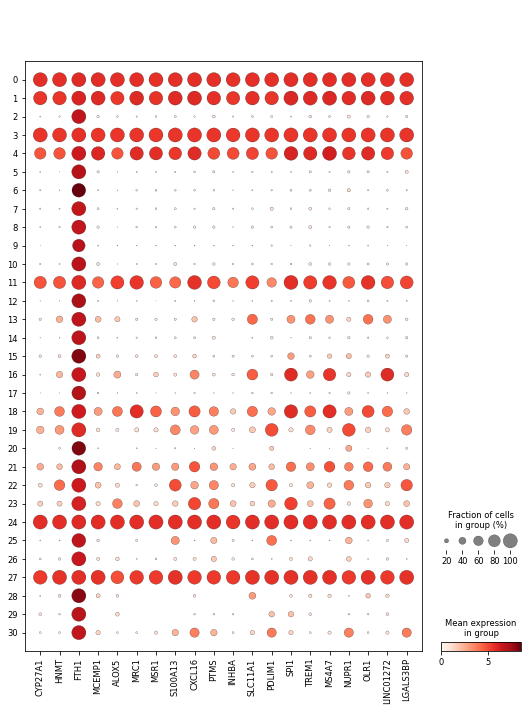

In [44]:
# mean expression of marker_genes from cluster 0 across all clusters
sc.pl.dotplot(adata, marker_genes, groupby='leiden');

### 4.4 Cluster Annotation using CellO classifier

In [18]:
cello_resource_loc = os.getcwd()

In [ ]:
model_prefix = "GSM3516673_MSK_LX682_NORMAL" # <-- The trained model will be stored in a file called GSM3516666_LX682_NORMAL.model.dill 

cello.scanpy_cello(
    adata, 
    clust_key='leiden',
    rsrc_loc=cello_resource_loc, 
    out_prefix=model_prefix,
    log_dir=os.getcwd()
)

After pre-training model with the genes in the target expression matrix, then we can run CellO below without training a new model in the step below.

In [ ]:

#cello.scanpy_cello(
    #adata,
    #clust_key='leiden',
    #rsrc_loc=cello_resource_loc,
    #model_file=f'{model_prefix}.model.dill'
#)

### 4.5 UMAP 

Cells identified with Cello classifier are visualized using UMAP

In [28]:
sc.tl.umap(adata)

... storing 'Most specific cell type' as categorical


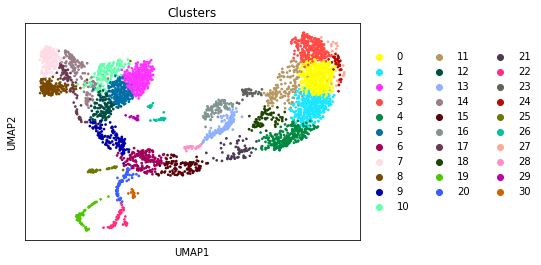

In [29]:
fig = sc.pl.umap(adata, color='leiden', title='Clusters', return_fig=True)

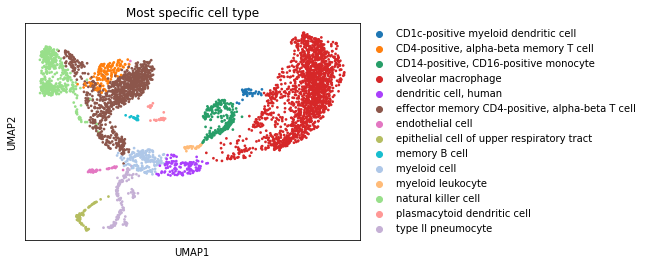

In [30]:
# Create UMAP plot with cells colored by most-specific predicted cell type
fig = sc.pl.umap(adata, color='Most specific cell type', return_fig=True)

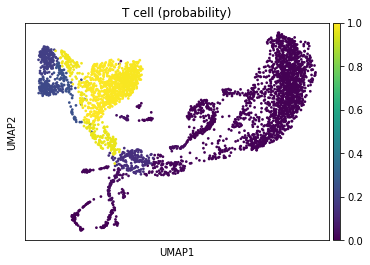

In [31]:
# UMAP showing the probability of being T cells
fig = sc.pl.umap(adata, color='T cell (probability)', vmin=0.0, vmax=1.0, return_fig=True)

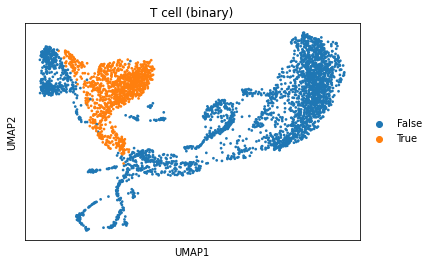

In [32]:
# UMAP showing the cells being classified as being T cells (Orange = T cells)
fig = sc.pl.umap(adata, color='T cell (binary)', return_fig=True)

### 4.6 Conclusion

From the cell identification and cluster annotation analysis, the scRNA sequencing data of lung tissue has predominantly following cell types

* CD1c-positive myeloid dendritic cell

* CD4-positive, alpha-beta memory T cell

* CD14-positive, CD16-positive monocyte

* alveiolar macrophage

* dendritic cell,human 

* effector memory CD4-positive, alpha-beta T cell

* endo-epithelial cell

* endothelial cell

* epithelial cell of upper respiratory tract

* memory B cell

* myeloid cell

* myeloid leukocyte

* natural killer cell

* plasmocytoid dentritic cell

* type II pneumocyte




### References

1. Luecken MD, Theis FJ. Current best practices in single-cell RNA-seq analysis: a tutorial. Mol Syst Biol. 2019 Jun 19;15(6):e8746. doi: 10.15252/msb.20188746. PMID: 31217225; PMCID: PMC6582955.

2. Matthew N. Bernstein, Colin N. Dewey,Annotating cell types in human single-cell RNA-seq data with CellO,STAR Protocols,
Volume 2, Issue 3,2021,100705,ISSN 2666-1667,https://doi.org/10.1016/j.xpro.2021.100705 (https://www.sciencedirect.com/science/article/pii/S2666166721004123)

3. Ziegenhain C, Vieth B, Parekh S, Reinius B, Guillaumet-Adkins A, Smets M, Leonhardt H, Heyn H, Hellmann I, Enard W (2017) Comparative analysis of single-cell RNA sequencing methods. Mol Cell 65: 631–643.e4

4. Svensson V, Natarajan KN, Ly L-H, Miragaia RJ, Labalette C, Macaulay IC, Cvejic A, Teichmann SA (2017) Power analysis of single-cell RNA-sequencing experiments. Nat Methods 14: 381–387

5. Patel AP, Tirosh I, Trombetta JJ, Shalek AK, Gillespie SM, Wakimoto H, Cahill DP, Nahed BV, Curry WT, Martuza RL et al (2014) Single-cell RNA-seq highlights intratumoral heterogeneity in primary glioblastoma. Science 344: 1396–1401

6. Kowalczyk MS, Tirosh I, Heckl D, Rao TN, Dixit A, Haas BJ, Schneider RK, Wagers AJ, Ebert BL, Regev A (2015) Single-cell RNA-seq reveals changes in cell cycle and differentiation programs upon aging of hematopoietic stem cells. Genome Res 25: 1860–1872 

7. Soneson C, Robinson MD (2018) Bias, robustness and scalability in single-cell differential expression analysis. Nat Methods 15: 255–261

8. Brennecke P, Anders S, Kim JK, Kołodziejczyk AA, Zhang X, Proserpio V, Baying B, Benes V, Teichmann SA, Marioni JC et al (2013) Accounting for technical noise in single-cell RNA-seq experiments. Nat Methods 10: 1093–1095

9. Finak G, McDavid A, Yajima M, Deng J, Gersuk V, Shalek AK, Slichter CK, Miller HW, Juliana McElrath M, Prlic M et al (2015) MAST: a flexible statistical framework for assessing transcriptional changes and characterizing heterogeneity in single-cell RNA sequencing data.

10. Ritchie ME, Phipson B, Wu D, Hu Y, Law CW, Shi W, Smyth GK (2015) limma powers differential expression analyses for RNA-sequencing and microarray studies. Nucleic Acids Res 43: e47

11. Johnson WE, Li C, Rabinovic A (2006) Adjusting batch effects in microarray expression data using empirical Bayes methods.

12. Buttner M, Miao Z, Wolf A, Teichmann SA, Theis FJ (2019) A test metric for assessing single-cell RNA-seq batch correction. Nat Methods 16: 43–49

13. Ilicic T, Kim JK, Kolodziejczyk AA, Bagger FO, McCarthy DJ, Marioni JC, Teichmann SA (2016) Classification of low quality cells from single-cell RNA-seq data. Genome Biol 17: 29

14. Griffiths JA, Scialdone A, Marioni JC (2018) Using single-cell genomics to understand developmental processes and cell fate decisions. Mol Syst Biol 14: e8046

**Appendix**

Pandas : Pandas is an open source library providing high-performance, easy-to-use data structures and data analysis tools for the Python programming language

Matplotlib : Matplotlib is a comprehensive library for creating static, animated, and interactive visualizations in Python

SCVI: Probabilistic models for single-cell omics data

Scanpy: Scanpy is an open sourcy library for analyzing single-cell gene expression data built jointly with anndata in python

Anndata: Python package for handling annotated data matrices in memory and on disk, positioned between pandas and xarray

CellO: CellO is a Python package for annotating cell types in single-cell RNA-seq data


In [50]:
!jupyter nbconvert --to html sc_RNAseq_analysis.ipynb

[NbConvertApp] WARNING | pattern 'sc_RNAseq_analysis.ipynb' matched no files
This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of prompting.
    Equivalent to: [--JupyterApp.answer_yes=True]
--exec